# Bijections and Distributions

This page provides an overview of the core components of bijx, namely **distributions** and **bijections**.

Both are implemented by subclasses of {class}`nnx.Module`, so they may contain parameters that can be flexibly optimized using gradient descent for any desired loss function.


## Distributions: density and exact sampling

```{eval-rst}
.. currentmodule:: bijx

A :class:`Distribution` captures two aspects of probability distributions:
```
- Evaluating the (log) probability density $p(x)$ at a given point $x$.
- A method to (pseudo-) random samples $x \sim p(x)$.

This is captured in this (simplified) class definition:
```python
class Distribution(nnx.Module):
    def sample(self, batch_shape=(), rng=None, **kwargs):
        return samples, log_density

    def log_density(self, x, **kwargs):
        return log_density
```

The interface is agnostic to the underlying data type.
The *event* $x$ can be any jax-compatible pytree, while a single array is most common.
The `log_density` should always be a single array (fundamentally scalar, although generically with batch dimensions).

**Shapes**:

To make shape handling manageable, several assumptions are made throughout bijx:
- All events $x$ (or its leaves, if a pytree) have a shape that splits into a batch and an *event shape*: `x.shape == batch_shape + event_shape`.
- In many contexts (e.g. CNNs) we split `event_shape == space_shape + channel_shape`.
- The *dimension* or *rank* refers to the number of axes. E.g. `event_dim == len(event_shape)`.
- The log-density is *always* passed explicitly.

Many convenient methods for shape inference can be found in {class}`ShapeInfo`.

For many fundamental bijections (see below), the methods assume that the log-density has the same batch dimensions as the event $x$: `log_density.shape == batch_shape`.
For bijections, this means we can directly infer the batch and event dimensions if both arguments are provided.
Since {attr}`Distribution.log_density` only takes one argument, the concrete distribution classes internally need to know about the event shape.
This can be implemented in whatever way is most convenient.

However, to support transforming distributions with bijections (see below), we need to be able to allocate an array of zeros for the log-density which are then transformed.
Thus, all distributions must also implement {attr}`Distribution.get_batch_shape` which should map $x$ to a tuple of integers.
For convenience, {class}`ArrayDistribution` implements this by taking a the event shape as argument in its constructor.
Various methods for processing shapes are implemented in {class}`ShapeInfo`.

Several concrete distributions are implemented, including normal, uniform, and Gaussian mixture models.

In [ ]:
import bijx
from flax import nnx

# example: a simple uniform distribution on the interval [0, 1].
prior = bijx.IndependentUniform(
    event_shape=(),           # here a scalar
    rngs=nnx.Rngs(sample=0),  # random number generator for sampling
)

# Drawing from a distribution always gives a tuple of `state`, `log_prob`.
x, lp = prior.sample(batch_shape=(10,))
print(f'{x.shape=}, {lp.shape=}')

x.shape=(10,), lp.shape=(10,)


```{eval-rst}
**API Reference**:

.. currentmodule:: bijx

.. autosummary::

   Distribution
   ArrayDistribution
   IndependentNormal
   IndependentUniform
   MultivariateNormal
   DiagonalNormal
   MixtureStack
   GaussianMixture
```

## Bijections: change of variables

A **bijection** in bijx represents an invertible variable transformation $f: X \to Y$, enhanced to also track how it affects probability densities. The latter is given by

$$
\log p_Y(y) = \log p_X(x) - \log \left| \det J_f(x) \right|
$$

where $y = f(x)$ and $J_f(x) = \nabla f (x)$ is the Jacobian.
In terms of array components of $x$ and $y = f(x)$ indexed by $i$ and $j$ this can be written as

$$
[J_f(x)]_{ij} =  \left. \frac{\partial f_i}{\partial x_j} \right|_{x} \,.
$$

Thus the enhanced versions of $f$ and $f^{-1}$, respectively, are implemented as

$$
\text{forward}: X \times \mathbb{R} \to Y \times \mathbb{R} \quad \text{and} \quad \text{reverse}: Y \times \mathbb{R} \to X \times \mathbb{R} \,.
$$


```python
class Bijection(nnx.Module):
    def forward(self, x, log_density, **kwargs):
        return y, updated_log_density  # log_density - log |det J_f(x)|

    def reverse(self, y, log_density, **kwargs):
        return x, updated_log_density  # log_density + log |det J_f(x)|
```

Any bijection can be inverted with {meth}`Bijection.invert`, yielding an instance of {class}`Inverse`, and bijections can be composed with {class}`Chain`.
A variant of the inverse class, {class}`CondInverse` is available that takes an additional boolean argument that controls whether the inverse is used.
{class}`ScanChain` is similar to {class}`Chain` except that applies `jax.lax.scan` over the parameters of the bijection. This is useful if the same kind of bijection with different parameters is applied sequentially.

See later sections for:

- [Scalar Bijections](basic) that transform single real numbers.
- [Meta Bijections](basic) that do not change density and only transform the representation, such as shapes.
- [Coupling Layers](coupling) for bijections that are conditional on some data, and can be used to build up complex multi-dimensional bijections from scalar or lower-dimensional ones.
- [Continuous Flows](continuous) for bijections that arise from solving ordinary differential equations (ODEs).

In [ ]:
# Example (see next page for simple transformations)

import jax.numpy as jnp

rngs = nnx.Rngs(0)

bijection = bijx.Chain(
    # here specifying initial values explicitly, see next page
    bijx.Scaling(jnp.array(2.0)),
    bijx.Shift(jnp.array(-1.0)),
    # here use random initialization
    bijx.Scaling((), rngs=rngs),
)

y, lp = bijection.forward(x, lp)
print('value changed:', jnp.all(x != y))

value changed: True


## Transformed

The idea of normalizing flows as a generative models is to define a parametrized model distribution $p(y)$ as the change of variable of a simple base distribution $q(x)$, or "prior", under a bijection $f$ that is to be optimized.
Representing $q$ as a {class}`Distribution` and $f$ as a {class}`Bijection`, we can chain the methods above to define a new kind of {class}`Distribution`.
This is implemented by {class}`Transformed`, which takes a distribution (prior) and a bijection (flow) as arguments.

A simple example:

```python
prior = bijx.IndependentNormal((2,), rngs=rngs)

bijection = bijx.Chain(
    bijx.Scaling(jnp.array([2.0, 1.0])),
    some_coupling_layer
)
nf = bijx.Transformed(prior, bijection)  # New distribution

samples, log_densities = nf.sample(batch_shape=(100,))
```

Note that in the final line no `rng` is passed. This is because, for convenience, the distribution class (here `prior`, and inherited by the transformed distribution) can hold an instance of {class}`nnx.Rngs` which is used by default.
Alternatively an explicit argument `rng` can be passed to `sample()`.

In [ ]:
# combine into a 'sampler' (which is again a distribution)
sampler = bijx.Transformed(prior, bijection)

# sample from the sampler
x, lp = sampler.sample(batch_shape=(7,))
print(f'{x.shape=}, {lp.shape=}')

x.shape=(7,), lp.shape=(7,)


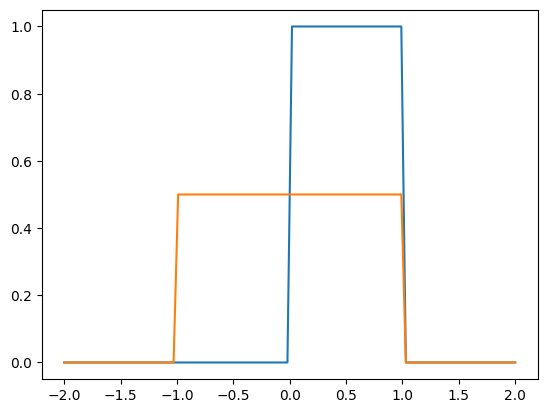

In [ ]:
import matplotlib.pyplot as plt

# all priors including samplers implement `log_prob`
x = jnp.linspace(-2, 2, 100)
plt.plot(x, jnp.exp(prior.log_density(x)))
plt.plot(x, jnp.exp(sampler.log_density(x)))
plt.show()

## Markov Chains

It may be desirable to generate asymptotically unbiased samples for a *true* distribution $p_{true}(x)$ that the sample approximates, $p_\theta(x) \approx p_{true}(x)$.
The simplest way to achieve this is using the independent [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm) (IMH) algorithm.

An interface similar to [blackjax](https://blackjax-devs.github.io/blackjax/index.html)'s `blackjax.irmh` is provided in {class}`IMH`.
The main difference to blackjax is that here, the proposal probabilities are computed at the same time as the samples.

Markov chains inherently generate one sample at a time, while normalizing flows can naturally generate batches of samples.
One option is of course to run multiple chains in parallel.
Besides that, {class}`BufferedSampler` wraps around a distribution and internally draws from a buffer when individual samples are requested, that is redrawn when the buffer is exhausted.

## Parameter manipulation & freezing

Both distributions and bijections are `nnx.Module`s and contain variables.

In order to indicate constant arrays that are not to be updated in gradient descent,
the {class}`Const` class, which is a subclass of `nnx.Variable`, can be used.

It may also be useful to freeze some parameters of a bijection or distributions that have been trained before, but should now be considered "fixed". One way to achieve this is demonstrated below.

In [ ]:
fixed = bijx.Scaling(bijx.Const(2.0))

# split into graph, constants, and parameters
graph, const, params = nnx.split(fixed, bijx.FrozenFilter, nnx.Param)
print(f'{const=}\n{params=}')

const=State({
  'scale': {
    'param': Const(
      value=2.0
    )
  }
})
params=State({})


In [ ]:
# by default, initialized as trainable parameter
trainable = bijx.Scaling((), rngs=nnx.Rngs(params=0))

graph, const, params = nnx.split(trainable, bijx.FrozenFilter, nnx.Param)
print(f'{const=}\n{params=}')

const=State({})
params=State({
  'scale': {
    'param': Param( # 1 (4 B)
      value=Array(1., dtype=float32)
    )
  }
})


Now for convenience, we can wrap bijections in the {class}`bijx.Frozen` class, marking all sub-parameters as constant.

In [ ]:
frozen = bijx.Frozen(trainable)
graph, const, params = nnx.split(frozen, bijx.FrozenFilter, nnx.Param)
print(f'{const=}\n{params=}')

const=State({
  'frozen': {
    'scale': {
      'param': Param( # 1 (4 B)
        value=Array(1., dtype=float32)
      )
    }
  }
})
params=State({})
